In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# read-in data and merge on 'parcelid'
train = pd.read_csv('train_2016_v2.csv')
train_prop = pd.read_csv('properties_2016.csv')
df_train = pd.merge(train,train_prop,on='parcelid',how='inner')

del train,train_prop

In [3]:
df_train.shape

(90275, 60)

In [4]:
# define function to reduce memory
def reduce_memory(df,verbose=True):
    num_dtypes = 'int16 int32 int64 float16 float32 float64'.split()
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in num_dtypes:
            col_min = df[col].min()
            col_max = df[col].max()
            # check if first letters start with 'flo'
            if str(col_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024 ** 2
    
    if verbose:
        print('Memory usage decreased to {:5.2f}Mb ({:.1f}% reduction)'.format(end_mem,100*(start_mem - end_mem) / start_mem))
    
    return df

In [5]:
reduce_memory(df_train)

Memory usage decreased to 16.36Mb (61.1% reduction)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.027603,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.168457,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.004002,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.021805,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.005001,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.035614,2016-12-30,1.0,NaN,NaN,1.0,1.0,NaN,4.0,...,NaN,NaN,43800.0,191000.0,2015.0,147200.0,2495.239990,NaN,NaN,6.037132e+13
90271,12046695,0.007000,2016-12-30,NaN,NaN,NaN,3.0,3.0,NaN,4.0,...,NaN,NaN,117893.0,161111.0,2015.0,43218.0,1886.540039,NaN,NaN,6.037301e+13
90272,12995401,-0.267822,2016-12-30,NaN,NaN,NaN,2.0,4.0,NaN,7.0,...,NaN,NaN,22008.0,38096.0,2015.0,16088.0,1925.699951,Y,14.0,6.037433e+13
90273,11402105,0.060211,2016-12-30,NaN,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,132991.0,165869.0,2015.0,32878.0,2285.570068,NaN,NaN,6.037601e+13


Missing data

In [6]:
# cols with more than 50 % missing values
na_count = df_train.isnull().sum().sort_values(ascending=False)
na_perc = na_count / df_train.shape[0]
na_perc = na_perc[na_perc > 0.5]
pd.DataFrame(na_perc,columns=['% missing'])

,% missing
buildingclasstypeid,0.999823
finishedsquarefeet13,0.999634
basementsqft,0.999524
storytypeid,0.999524
yardbuildingsqft26,0.998948
fireplaceflag,0.997541
architecturalstyletypeid,0.997109
typeconstructiontypeid,0.996688
finishedsquarefeet6,0.995336
decktypeid,0.992711


In [7]:
mis_col_count = len(na_perc[na_perc > 0])
print(f'There are {mis_col_count} columns with missing values.')

There are 29 columns with missing values.


Drop columns with more than 50% missing values

In [8]:
mis_cols = na_perc.index
df_train = df_train.drop(labels=mis_cols,axis=1)
df_train.shape

(90275, 31)

Drop `parcelid` column

In [9]:
df_train = df_train.drop(labels='parcelid',axis=1)

Get lists of numerical/categorical features with missing data.

In [10]:
# get all the numerical columns/features
num_cols = df_train.dtypes[df_train.dtypes != 'object'].index
num_na_cols = [col for col in df_train[num_cols].columns if df_train[col].isnull().sum() > 0]

# get all the categorical features
cat_cols = df_train.dtypes[df_train.dtypes == 'object'].index
cat_na_cols = [col for col in df_train[cat_cols].columns if df_train[col].isnull().sum() > 0]

#### Imputing data

In [11]:
# impute numerical features
impute_num = Imputer(missing_values=np.nan,strategy='mean',axis=0)
impute_num = impute_num.fit(df_train[num_na_cols])
df_train[num_na_cols] = impute_num.transform(df_train[num_na_cols])

# Manually impute categorical features
# 'propertycountylandusecode' feature
most_frequent = df_train['propertycountylandusecode'].value_counts().index[0]
df_train['propertycountylandusecode'] = df_train['propertycountylandusecode'].fillna(most_frequent)

# 'propertyzoningdesc' feature
most_frequent = df_train['propertyzoningdesc'].value_counts().index[0]
df_train['propertyzoningdesc'] = df_train['propertyzoningdesc'].fillna(most_frequent)

In [12]:
df_train.isnull().sum()

logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
propertyzoningdesc              0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractand

Now we have dealt with all the missing data.

Drop columns: `propertycountylandusecode`,`propertylandusetypeid`, `transactiondate`

In [13]:
drop_cols = ['propertycountylandusecode','propertyzoningdesc','transactiondate']
df_train = df_train.drop(labels=drop_cols,axis=1)
df_train.shape

(90275, 27)

#### Correlation heatmap of the features

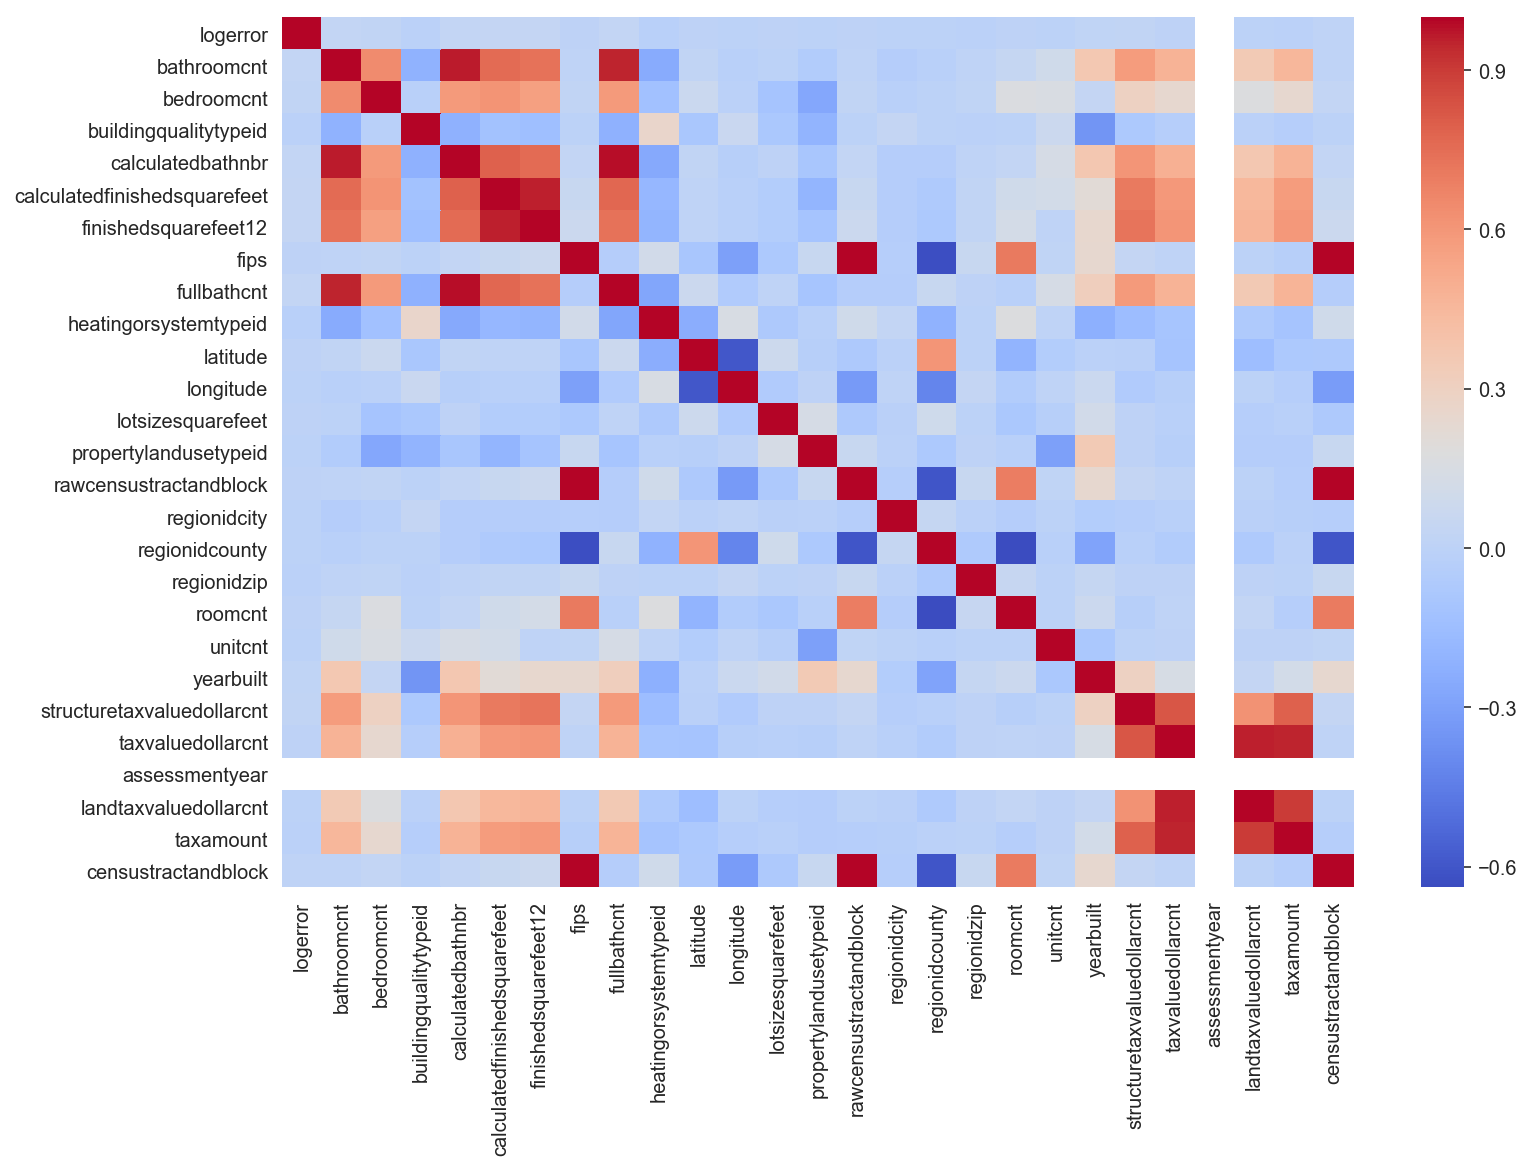

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train.corr(),cmap='coolwarm')

Train/Test split data

In [15]:
indep_cols = list(df_train.columns)
indep_cols.remove('logerror')
X = df_train[indep_cols]
y = df_train['logerror']

In [16]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

Train Linear model

In [17]:
# import linear regression and instantiate
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

In [18]:
# train/fit model
linear_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
coef = linear_model.coef_
pd.DataFrame(data=coef,columns=['coefficients'])

,coefficients
0,-1.317344e-02
1,5.549447e-04
2,5.655752e-04
3,7.964468e-03
4,5.368979e-06
5,5.038250e-06
6,7.258774e-03
7,3.590366e-03
8,-7.551858e-04
9,4.770825e-10


Testing model/predicting data:

In [20]:
# predict using test data
prediction = linear_model.predict(X_test)

Residuals

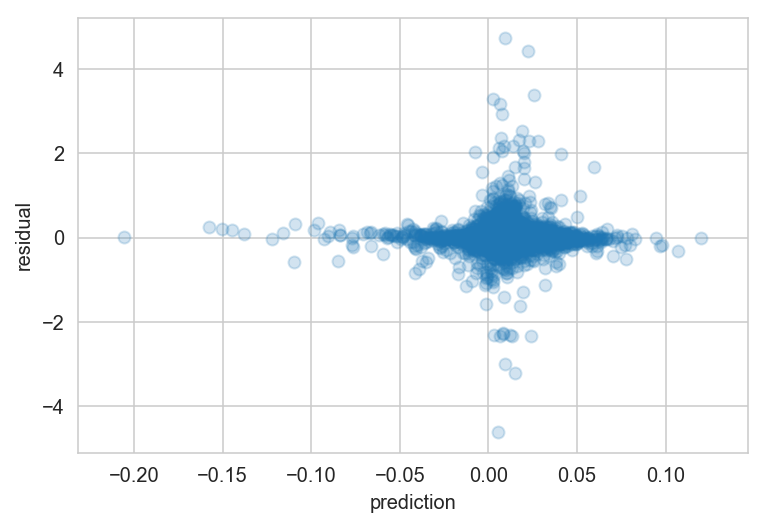

In [21]:
res = y_test - prediction
plt.scatter(x=prediction,y=res,alpha=0.2)
plt.xlabel('prediction')
plt.ylabel('residual');

In [22]:
# import metrics
from sklearn import metrics
print('MAE',metrics.mean_absolute_error(y_test,prediction))

MAE 0.06852282169875547


## Regularization

In [23]:
from sklearn.linear_model import Lasso,Ridge,ElasticNet

Lasso:

In [24]:
lasso = Lasso(alpha=0.01)
lasso_pred = lasso.fit(X_train,y_train).predict(X_test)

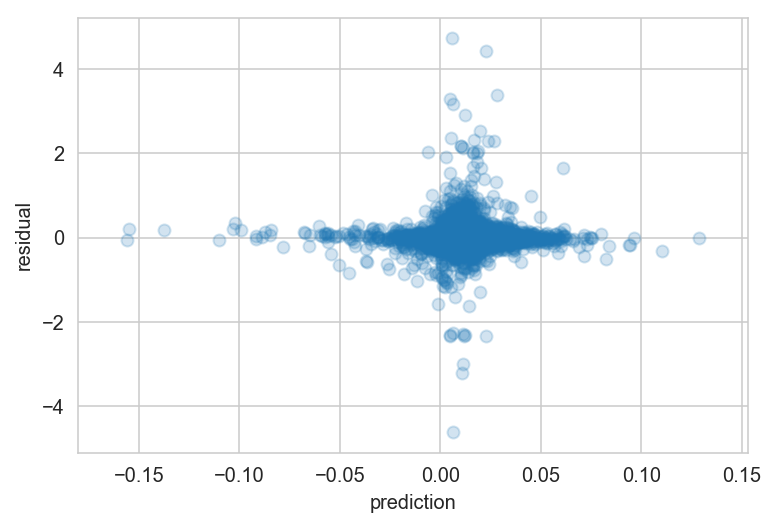

In [25]:
res = y_test - lasso_pred
plt.scatter(x=lasso_pred,y=res,alpha=0.2)
plt.xlabel('prediction')
plt.ylabel('residual');

Columns that were selected out:

In [26]:
pd.Series(lasso.fit(X_train,y_train).coef_,index=X_train.columns)

bathroomcnt                    -0.000000e+00
bedroomcnt                     -0.000000e+00
buildingqualitytypeid           0.000000e+00
calculatedbathnbr              -0.000000e+00
calculatedfinishedsquarefeet    3.046811e-06
finishedsquarefeet12            6.068712e-06
fips                            0.000000e+00
fullbathcnt                    -0.000000e+00
heatingorsystemtypeid          -0.000000e+00
latitude                        1.072261e-10
longitude                       4.169932e-09
lotsizesquarefeet               6.448270e-09
propertylandusetypeid           0.000000e+00
rawcensustractandblock         -9.457979e-09
regionidcity                   -3.533372e-09
regionidcounty                  4.515030e-06
regionidzip                    -3.993348e-07
roomcnt                        -0.000000e+00
unitcnt                        -0.000000e+00
yearbuilt                       3.177184e-05
structuretaxvaluedollarcnt     -8.528051e-08
taxvaluedollarcnt               1.252813e-07
assessment

In [27]:
print(metrics.mean_absolute_error(y_test,lasso_pred))

0.06839451410316948


Ridge:

In [28]:
ridge = Ridge(alpha=0.01)
ridge_pred = ridge.fit(X_train,y_train).predict(X_test)

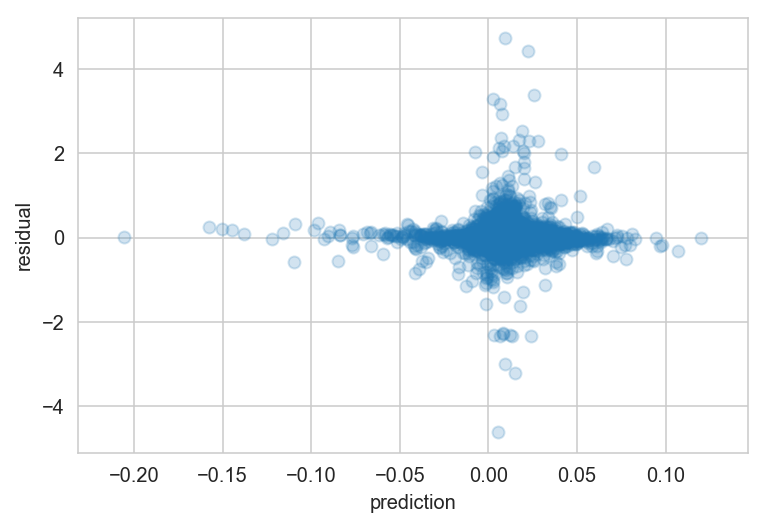

In [29]:
res = y_test - ridge_pred
plt.scatter(x=ridge_pred,y=res,alpha=0.2)
plt.xlabel('prediction')
plt.ylabel('residual');

In [30]:
print(metrics.mean_absolute_error(y_test,ridge_pred))

0.0685228206047037


Elastic Net:

In [31]:
en = ElasticNet(alpha=0.01)
en_pred = en.fit(X_train,y_train).predict(X_test)

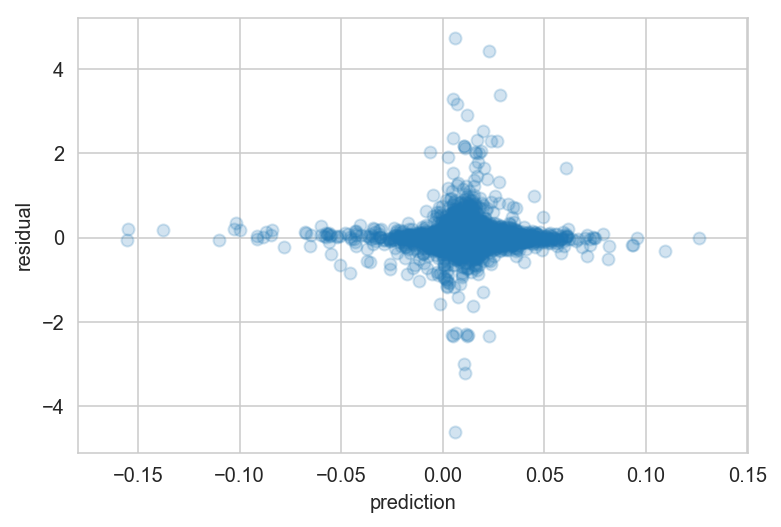

In [32]:
res = y_test - en_pred
plt.scatter(x=en_pred,y=res,alpha=0.2)
plt.xlabel('prediction')
plt.ylabel('residual');

In [33]:
print(metrics.mean_absolute_error(y_test,en_pred))

0.06840018233407856


Lasso performed slightly better compared to other models